In [1]:
from fisher_py.data.business import Scan
from fisher_py import RawFile
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import pickle
import os
import re
from tqdm import tqdm

In [2]:
def wholeCasting(folder_path, cast_path):
    os.chdir(folder_path)

    def helper_regex(text):
        match = re.search(rf"{'Full'}\s+(\w+)", text)
        if match:
            return match.group(1)
        return None
    def find_matching_keys(sequence: str, substring_dict: dict) -> list:
        return [key for key, substrings in substring_dict.items() if any(substring in sequence for substring in substrings)]


    files_1 = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    substring_dict_sample = {"Heart": ["Heart"], "Kidney": ["Kidney"], "Spleen": ["Spleen"], "Lung": ["Lung"], "SmInt": ["SmInt"] }
    substring_dict_elution = {"PLRPS": ["PLRPS"], "CESI": ["CESI"]}

    files = [s for s in files_1]

    file_name = []

    scan_number = []
    retention_time = []
    cast_spectra = []

    mz_value = []

    for raw_name in files:
        raw = RawFile(raw_name)
        print(raw_name)
        for i in tqdm(range(1, raw.number_of_scans), desc="Processing scans", ncols=100):
            raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)

            if str(helper_regex(raw_scan.scan_type)) == 'ms2':
                file_name.append(raw_name)
                scan_number.append(raw_scan.scan_statistics.scan_number)
                retention_time.append(raw.get_retention_time_from_scan_number(raw_scan.scan_statistics.scan_number))
                mz_value.append(float(re.findall(r'[\d]*[.][\d]+', raw_scan.scan_type)[1]))

                data_intensities = [0]*1600
                scan_masses = raw_scan.preferred_masses
                scan_intensities = raw_scan.preferred_intensities

                for j in range(0,len(scan_masses)):
                    index = round(scan_masses[j])
                    if index > 400 and index < 2000:
                        data_intensities[index-400] = scan_intensities[j] + data_intensities[index-400]
                data_intensities = np.array(data_intensities)
                max_value = np.max(data_intensities)
                data_intensities_norm = data_intensities / max_value
                data_intensities_norm = data_intensities_norm.astype(np.float16)
                data_intensities_norm.tolist()
                cast_spectra.append(data_intensities_norm)

    scan_dict = {'sample_name': file_name, 'scan': scan_number, 'retntion time': retention_time, 'm/z': mz_value, 'cast spectra': cast_spectra}

    with open(cast_path, "wb") as f:
        pickle.dump(scan_dict, f)

    return()

In [3]:
wholeCasting(folder_path='D:/test1/', cast_path='test')

20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep01.raw


Processing scans: 100%|███████████████████████████████████████| 12456/12456 [02:47<00:00, 74.37it/s]


20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep02.raw


Processing scans: 100%|███████████████████████████████████████| 12624/12624 [02:40<00:00, 78.44it/s]


20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep03.raw


Processing scans: 100%|███████████████████████████████████████| 12198/12198 [02:33<00:00, 79.58it/s]


20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep01.raw


Processing scans: 100%|███████████████████████████████████████| 15785/15785 [02:53<00:00, 90.90it/s]


20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep02.raw


Processing scans: 100%|███████████████████████████████████████| 15856/15856 [03:17<00:00, 80.09it/s]


20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep03.raw


Processing scans: 100%|███████████████████████████████████████| 15739/15739 [03:17<00:00, 79.73it/s]


()

In [4]:
with open('D:/test1/test', "rb") as f:
    loaded_cast_dict = pickle.load(f)

   bin_start_min  bin_end_min  expanded_start_min  expanded_end_min  \
0            0.0         10.0            0.994049              12.5   
1           10.0         20.0            7.500000              22.5   
2           20.0         30.0           17.500000              32.5   
3           30.0         40.0           27.500000              42.5   
4           40.0         50.0           37.500000              52.5   
5           50.0         60.0           47.500000              62.5   
6           60.0         70.0           57.500000              72.5   
7           70.0         80.0           67.500000              82.5   

   n_in_expanded_window  n_valid_used  target_n  avg_rt_drift  
0                   902            50        50     -1.038747  
1                  1250            50        50     -0.334364  
2                  2313            50        50     -1.303329  
3                  3557            50        50     -1.928154  
4                  3476            50   

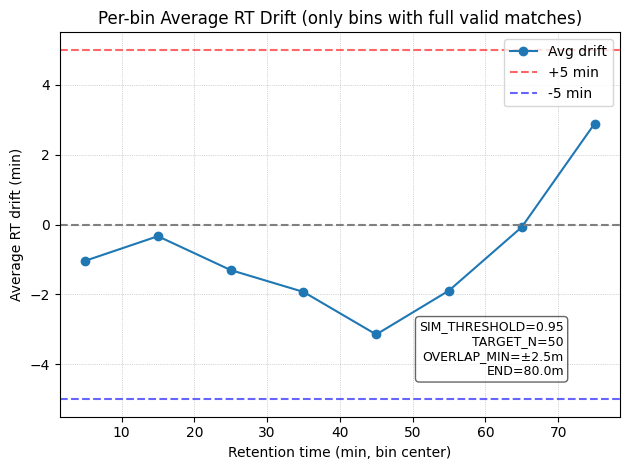

In [101]:
import numpy as np
import pandas as pd
from math import floor, ceil
import matplotlib.pyplot as plt

# ------------------------------------------------------
# Similarity engine (cosine). Replace with your own if you have one.
def _to_1d_float_array(x):
    if isinstance(x, np.ndarray):
        arr = x
    elif isinstance(x, (list, tuple)):
        arr = np.asarray(x, dtype=float)
    else:
        try:
            arr = np.asarray(x, dtype=float).ravel()
        except Exception:
            return None
    return arr.ravel().astype(float, copy=False)

def engine(a, b):
    va = _to_1d_float_array(a); vb = _to_1d_float_array(b)
    if va is None or vb is None or va.size == 0 or vb.size == 0:
        return -np.inf
    if va.shape != vb.shape:
        n = min(va.size, vb.size)
        if n == 0:
            return -np.inf
        va, vb = va[:n], vb[:n]
    denom = np.linalg.norm(va) * np.linalg.norm(vb)
    if denom == 0:
        return -np.inf
    return float(np.dot(va, vb) / denom)
# ------------------------------------------------------

# ---- Config ----
SIM_THRESHOLD = 0.95
MZ_WINDOW     = 1.0
TARGET_N      = 50        # desired number of valid drifts per bin
BIN_WIDTH     = 10.0      # minutes
OVERLAP_MIN   = 2.5       # overlap on each side of each bin (minutes)
FORCE_BIN_END_MIN = 80.0  # <-- NEW: force bins to end at this minute (set None to auto)
SAMPLE_WITH_REPLACEMENT_IF_NEEDED = False  # keep False to avoid duplicates

# ---- DataFrames from your dict ----
df = pd.DataFrame(loaded_cast_dict)

# Work exactly with your column names (typo intentional)
df_t2 = df[df["sample_name"] == "test2.raw"].copy()
df_t1 = df[df["sample_name"] == "test1.raw"].copy()
if df_t1.empty:
    raise ValueError("No reference rows found for 'test1.raw'.")

# Reference arrays (static)
mz_ref   = df_t1["m/z"].to_numpy()
rt_ref   = df_t1["retntion time"].to_numpy()
cast_ref = df_t1["cast spectra"].to_numpy(object)

def collect_valid_drifts(bin_df, target_n=TARGET_N):
    """
    Try to collect up to target_n valid drifts from bin_df.
    Discards scans that have no valid match (NaN).
    Returns list of drifts (len <= target_n).
    """
    if bin_df.empty:
        return []

    if SAMPLE_WITH_REPLACEMENT_IF_NEEDED:
        tries = 0
        max_tries = max(200, target_n * 20)
        drifts = []
        while len(drifts) < target_n and tries < max_tries:
            row = bin_df.sample(n=1, replace=True).iloc[0]
            tries += 1

            mz_i   = row["m/z"]
            rt_i   = row["retntion time"]
            cast_i = row["cast spectra"]

            mask = np.abs(mz_ref - mz_i) < MZ_WINDOW
            idxs = np.where(mask)[0]

            match_count = 0
            rt_sum = 0.0
            for j in idxs:
                if engine(cast_i, cast_ref[j]) > SIM_THRESHOLD:
                    match_count += 1
                    rt_sum += rt_ref[j]

            if match_count > 0:
                avg_rt = rt_sum / match_count
                drifts.append(rt_i - avg_rt)
        return drifts
    else:
        bin_df_shuf = bin_df.sample(frac=1.0, replace=False, random_state=42).reset_index(drop=True)
        drifts = []
        for _, row in bin_df_shuf.iterrows():
            if len(drifts) >= target_n:
                break
            mz_i   = row["m/z"]
            rt_i   = row["retntion time"]
            cast_i = row["cast spectra"]

            mask = np.abs(mz_ref - mz_i) < MZ_WINDOW
            idxs = np.where(mask)[0]

            match_count = 0
            rt_sum = 0.0
            for j in idxs:
                if engine(cast_i, cast_ref[j]) > SIM_THRESHOLD:
                    match_count += 1
                    rt_sum += rt_ref[j]

            if match_count > 0:
                avg_rt = rt_sum / match_count
                drifts.append(rt_i - avg_rt)
        return drifts

# ---- Build bins over test2.raw ----
if df_t2.empty:
    raise ValueError("No rows found for 'test2.raw'.")

rt_min = float(df_t2["retntion time"].min())
rt_max = float(df_t2["retntion time"].max())

start_edge = BIN_WIDTH * floor(rt_min / BIN_WIDTH)
end_edge   = BIN_WIDTH * ceil(rt_max / BIN_WIDTH)

# --- Force the bin end if requested ---
if FORCE_BIN_END_MIN is not None:
    end_edge = float(FORCE_BIN_END_MIN)
    if end_edge <= start_edge:
        raise ValueError(f"FORCE_BIN_END_MIN ({FORCE_BIN_END_MIN}) must be > start_edge ({start_edge}).")

bins = []
t = start_edge
while t < end_edge:
    bins.append((t, t + BIN_WIDTH))
    t += BIN_WIDTH

# ---- Compute per-bin drifts (with ±OVERLAP_MIN on each side) ----
records = []
for (t0, t1) in bins:
    # Expanded window, clipped to overall RT range
    win_start = max(t0 - OVERLAP_MIN, rt_min)
    win_end   = min(t1 + OVERLAP_MIN, rt_max)

    # Left-closed, right-open selection
    bin_df = df_t2[(df_t2["retntion time"] >= win_start) & (df_t2["retntion time"] < win_end)].copy()

    drifts = collect_valid_drifts(bin_df, target_n=TARGET_N)
    n_valid = len(drifts)
    avg_drift = float(np.mean(drifts)) if n_valid > 0 else float("nan")

    records.append({
        "bin_start_min": t0,
        "bin_end_min": t1,
        "expanded_start_min": win_start,
        "expanded_end_min": win_end,
        "n_in_expanded_window": len(bin_df),
        "n_valid_used": n_valid,
        "target_n": TARGET_N,
        "avg_rt_drift": avg_drift,
    })

# ---- Results table ----
result_df = pd.DataFrame.from_records(records)
print(result_df)

# Weighted overall average drift (by #valid per bin)
overall = (
    np.average(
        [r["avg_rt_drift"] for r in records if not np.isnan(r["avg_rt_drift"])],
        weights=[r["n_valid_used"] for r in records if not np.isnan(r["avg_rt_drift"])]
    )
    if any(r["n_valid_used"] > 0 for r in records) else float("nan")
)
print(f"\nWeighted overall avg drift (by #valid per bin): {overall}")

# --- Prep for plotting ---
plot_df = result_df.copy()
plot_df["bin_center_min"] = 0.5 * (plot_df["bin_start_min"] + plot_df["bin_end_min"])

# Keep only bins with exactly target_n valid matches
plot_df_valid = plot_df[
    (~np.isnan(plot_df["avg_rt_drift"])) & (plot_df["n_valid_used"] == plot_df["target_n"])
].copy()

# --- Plot: Average RT drift per bin with ±5 lines ---
plt.figure()
plt.plot(plot_df_valid["bin_center_min"], plot_df_valid["avg_rt_drift"], 
         marker="o", label="Avg drift")

# Reference lines
plt.axhline(0.0, linestyle="--", color="gray")
plt.axhline(5.0, linestyle="--", color="red", alpha=0.6, label="+5 min")
plt.axhline(-5.0, linestyle="--", color="blue", alpha=0.6, label="-5 min")

plt.xlabel("Retention time (min, bin center)")
plt.ylabel("Average RT drift (min)")
plt.title("Per-bin Average RT Drift (only bins with full valid matches)")
plt.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.legend()

# Corner box (bottom-right)
plt.text(
    0.9, 0.1,
    f"SIM_THRESHOLD={SIM_THRESHOLD}\nTARGET_N={TARGET_N}\nOVERLAP_MIN=±{OVERLAP_MIN}m\nEND={end_edge}m",
    transform=plt.gca().transAxes, fontsize=9,
    verticalalignment="bottom", horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
)

plt.tight_layout()
plt.show()


20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep02.raw: weighted overall avg drift = -0.079 min (kept 8 bins; TARGET_N=20)
20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep03.raw: weighted overall avg drift = -0.210 min (kept 8 bins; TARGET_N=20)
20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep01.raw: weighted overall avg drift = -0.177 min (kept 7 bins; TARGET_N=20)
20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep02.raw: weighted overall avg drift = -0.998 min (kept 7 bins; TARGET_N=20)
20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep03.raw: weighted overall avg drift = 0.676 min (kept 7 bins; TARGET_N=20)


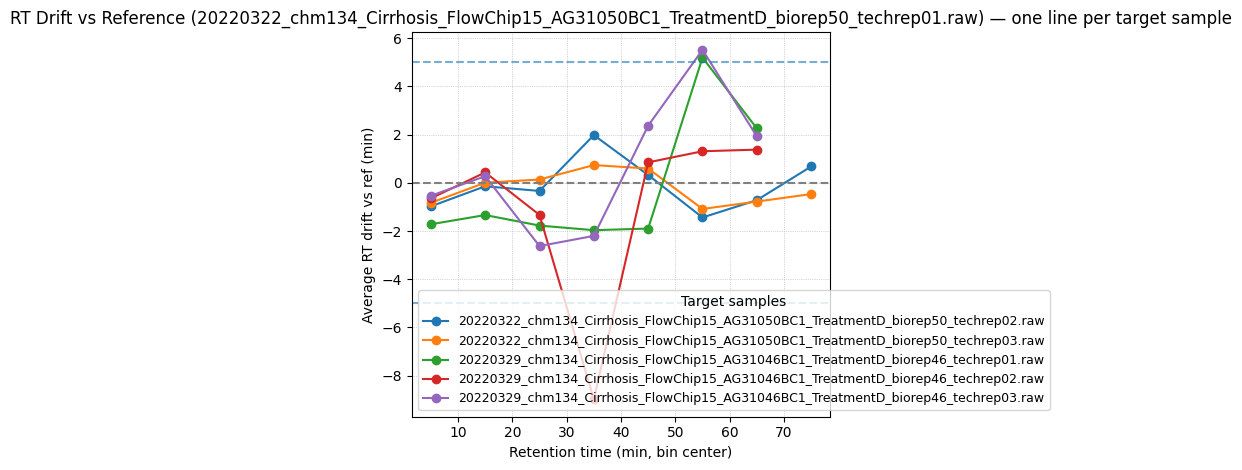

In [7]:
import numpy as np
import pandas as pd
from math import floor, ceil
import matplotlib.pyplot as plt

# ------------------------------------------------------
# Similarity engine (cosine). Your original version.
def _to_1d_float_array(x):
    if isinstance(x, np.ndarray):
        arr = x
    elif isinstance(x, (list, tuple)):
        arr = np.asarray(x, dtype=float)
    else:
        try:
            arr = np.asarray(x, dtype=float).ravel()
        except Exception:
            return None
    return arr.ravel().astype(float, copy=False)

def engine(a, b):
    va = _to_1d_float_array(a); vb = _to_1d_float_array(b)
    if va is None or vb is None or va.size == 0 or vb.size == 0:
        return -np.inf
    if va.shape != vb.shape:
        n = min(va.size, vb.size)
        if n == 0:
            return -np.inf
        va, vb = va[:n], vb[:n]
    denom = np.linalg.norm(va) * np.linalg.norm(vb)
    if denom == 0:
        return -np.inf
    return float(np.dot(va, vb) / denom)
# ------------------------------------------------------

# ---- Config (same defaults you used) ----
SIM_THRESHOLD  = 0.95
MZ_WINDOW      = 1.0
TARGET_N       = 20         # desired number of valid drifts per bin
BIN_WIDTH      = 10.0       # minutes
OVERLAP_MIN    = 2.5        # overlap on each side of each bin (minutes)
FORCE_BIN_END_MIN = 80.0    # force bins to end at this minute (set None to auto)
SAMPLE_WITH_REPLACEMENT_IF_NEEDED = False  # keep False to avoid duplicates

# ---- DataFrame from your dict ----
df = pd.DataFrame(loaded_cast_dict)

# Ensure we have at least 6 samples
sample_order = df["sample_name"].dropna().unique().tolist()
if len(sample_order) < 6:
    raise ValueError(f"Expected 6 samples, found {len(sample_order)}: {sample_order}")

ref_name = sample_order[0]
target_names = sample_order[1:6]  # the other five

# ---- Reference arrays (static) ----
df_ref = df[df["sample_name"] == ref_name].copy()
if df_ref.empty:
    raise ValueError(f"No reference rows found for '{ref_name}'.")

mz_ref   = df_ref["m/z"].to_numpy()
rt_ref   = df_ref["retntion time"].to_numpy()
cast_ref = df_ref["cast spectra"].to_numpy(object)

def collect_valid_drifts(bin_df, target_n=TARGET_N):
    """
    Try to collect up to target_n valid drifts from bin_df.
    Discards scans that have no valid match (NaN).
    Returns list of drifts (len <= target_n).
    """
    if bin_df.empty:
        return []

    if SAMPLE_WITH_REPLACEMENT_IF_NEEDED:
        tries = 0
        max_tries = max(200, target_n * 20)
        drifts = []
        while len(drifts) < target_n and tries < max_tries:
            row = bin_df.sample(n=1, replace=True).iloc[0]
            tries += 1

            mz_i   = row["m/z"]
            rt_i   = row["retntion time"]
            cast_i = row["cast spectra"]

            mask = np.abs(mz_ref - mz_i) < MZ_WINDOW
            idxs = np.where(mask)[0]

            match_count = 0
            rt_sum = 0.0
            for j in idxs:
                if engine(cast_i, cast_ref[j]) > SIM_THRESHOLD:
                    match_count += 1
                    rt_sum += rt_ref[j]

            if match_count > 0:
                avg_rt = rt_sum / match_count
                drifts.append(rt_i - avg_rt)
        return drifts
    else:
        bin_df_shuf = bin_df.sample(frac=1.0, replace=False, random_state=42).reset_index(drop=True)
        drifts = []
        for _, row in bin_df_shuf.iterrows():
            if len(drifts) >= target_n:
                break
            mz_i   = row["m/z"]
            rt_i   = row["retntion time"]
            cast_i = row["cast spectra"]

            mask = np.abs(mz_ref - mz_i) < MZ_WINDOW
            idxs = np.where(mask)[0]

            match_count = 0
            rt_sum = 0.0
            for j in idxs:
                if engine(cast_i, cast_ref[j]) > SIM_THRESHOLD:
                    match_count += 1
                    rt_sum += rt_ref[j]

            if match_count > 0:
                avg_rt = rt_sum / match_count
                drifts.append(rt_i - avg_rt)
        return drifts

def build_bins_for_target(df_target):
    """Build left-closed, right-open bins on target sample RT, optionally forced to end at FORCE_BIN_END_MIN."""
    if df_target.empty:
        return [], np.nan, np.nan

    rt_min = float(df_target["retntion time"].min())
    rt_max = float(df_target["retntion time"].max())

    start_edge = BIN_WIDTH * floor(rt_min / BIN_WIDTH)
    end_edge   = BIN_WIDTH * ceil(rt_max / BIN_WIDTH)

    if FORCE_BIN_END_MIN is not None:
        end_edge = float(FORCE_BIN_END_MIN)
        if end_edge <= start_edge:
            raise ValueError(f"FORCE_BIN_END_MIN ({FORCE_BIN_END_MIN}) must be > start_edge ({start_edge}).")

    bins = []
    t = start_edge
    while t < end_edge:
        bins.append((t, t + BIN_WIDTH))
        t += BIN_WIDTH
    return bins, rt_min, rt_max

def compute_drift_table_for_target(df_target):
    """Compute per-bin average drift (against ref) for one target sample."""
    bins, rt_min, rt_max = build_bins_for_target(df_target)
    records = []

    for (t0, t1) in bins:
        # Expanded window, clipped to target's RT range
        win_start = max(t0 - OVERLAP_MIN, rt_min)
        win_end   = min(t1 + OVERLAP_MIN, rt_max)

        bin_df = df_target[(df_target["retntion time"] >= win_start) &
                           (df_target["retntion time"] <  win_end)].copy()

        drifts = collect_valid_drifts(bin_df, target_n=TARGET_N)
        n_valid = len(drifts)
        avg_drift = float(np.mean(drifts)) if n_valid > 0 else float("nan")

        records.append({
            "bin_start_min": t0,
            "bin_end_min": t1,
            "expanded_start_min": win_start,
            "expanded_end_min": win_end,
            "n_in_expanded_window": len(bin_df),
            "n_valid_used": n_valid,
            "target_n": TARGET_N,
            "avg_rt_drift": avg_drift,
        })

    result_df = pd.DataFrame.from_records(records)
    result_df["bin_center_min"] = 0.5 * (result_df["bin_start_min"] + result_df["bin_end_min"])

    # Keep only bins with exactly target_n valid matches
    plot_df_valid = result_df[
        (~np.isnan(result_df["avg_rt_drift"])) &
        (result_df["n_valid_used"] == result_df["target_n"])
    ].copy()

    return result_df, plot_df_valid

# ---- Compute & Plot (overlay the 5 targets) ----
plt.figure()
any_series = False

for tname in target_names:
    dft = df[df["sample_name"] == tname].copy()
    if dft.empty:
        print(f"Warning: no rows for target '{tname}', skipping.")
        continue

    res_df, plot_df_valid = compute_drift_table_for_target(dft)

    # Optional: print per-target weighted overall avg drift
    if (plot_df_valid.shape[0] > 0):
        weights = plot_df_valid["n_valid_used"].to_numpy()
        vals    = plot_df_valid["avg_rt_drift"].to_numpy()
        wavg    = np.average(vals, weights=weights)
        print(f"{tname}: weighted overall avg drift = {wavg:.3f} min "
              f"(kept {plot_df_valid.shape[0]} bins; TARGET_N={TARGET_N})")
    else:
        print(f"{tname}: no bins with exactly TARGET_N={TARGET_N} valid matches.")

    if not plot_df_valid.empty:
        plt.plot(
            plot_df_valid["bin_center_min"],
            plot_df_valid["avg_rt_drift"],
            marker="o",
            label=tname
        )
        any_series = True

# Reference lines
plt.axhline(0.0, linestyle="--", color="gray")
plt.axhline(5.0, linestyle="--", alpha=0.6)
plt.axhline(-5.0, linestyle="--", alpha=0.6)

plt.xlabel("Retention time (min, bin center)")
plt.ylabel("Average RT drift vs ref (min)")
plt.title(f"RT Drift vs Reference ({ref_name}) — one line per target sample")
if any_series:
    plt.legend(title="Target samples", fontsize=9)
plt.grid(True, which="both", linestyle=":", linewidth=0.5)

# Corner info box
# plt.text(
#     0.98, 0.02,
#     f"REF={ref_name}\nSIM_THRESHOLD={SIM_THRESHOLD}\nTARGET_N={TARGET_N}\n"
#     f"BIN={BIN_WIDTH}m, overlap=±{OVERLAP_MIN}m\nEND={FORCE_BIN_END_MIN}m",
#     transform=plt.gca().transAxes, fontsize=9,
#     va="bottom", ha="right",
#     bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
# )

plt.tight_layout()
plt.show()


20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep02.raw: weighted overall avg drift = -0.213 min (kept 8 bins with ≥1 valid match; TARGET_N=50)
20220322_chm134_Cirrhosis_FlowChip15_AG31050BC1_TreatmentD_biorep50_techrep03.raw: weighted overall avg drift = -0.115 min (kept 8 bins with ≥1 valid match; TARGET_N=50)
20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep01.raw: weighted overall avg drift = -0.391 min (kept 8 bins with ≥1 valid match; TARGET_N=50)
20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep02.raw: weighted overall avg drift = -0.459 min (kept 8 bins with ≥1 valid match; TARGET_N=50)
20220329_chm134_Cirrhosis_FlowChip15_AG31046BC1_TreatmentD_biorep46_techrep03.raw: weighted overall avg drift = -0.086 min (kept 8 bins with ≥1 valid match; TARGET_N=50)


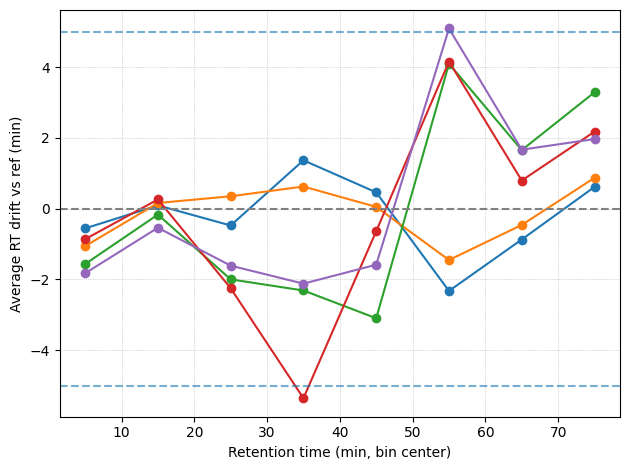

In [10]:
import numpy as np
import pandas as pd
from math import floor, ceil
import matplotlib.pyplot as plt

# ------------------------------------------------------
# Cosine similarity (unchanged)
def _to_1d_float_array(x):
    if isinstance(x, np.ndarray):
        arr = x
    elif isinstance(x, (list, tuple)):
        arr = np.asarray(x, dtype=float)
    else:
        try:
            arr = np.asarray(x, dtype=float).ravel()
        except Exception:
            return None
    return arr.ravel().astype(float, copy=False)

def engine(a, b):
    va = _to_1d_float_array(a); vb = _to_1d_float_array(b)
    if va is None or vb is None or va.size == 0 or vb.size == 0:
        return -np.inf
    if va.shape != vb.shape:
        n = min(va.size, vb.size)
        if n == 0:
            return -np.inf
        va, vb = va[:n], vb[:n]
    denom = np.linalg.norm(va) * np.linalg.norm(vb)
    if denom == 0:
        return -np.inf
    return float(np.dot(va, vb) / denom)
# ------------------------------------------------------

# ---- Config ----
SIM_THRESHOLD  = 0.95
MZ_WINDOW      = 1.0
TARGET_N       = 50          # desired number of matches to try for (but we accept >=1)
BIN_WIDTH      = 10.0        # minutes
OVERLAP_MIN    = 2.5         # overlap on each side (minutes)
FORCE_BIN_END_MIN = 80.0     # set None to auto end per target
SAMPLE_WITH_REPLACEMENT_IF_NEEDED = False  # keep False to avoid duplicates

# ---- DataFrame ----
df = pd.DataFrame(loaded_cast_dict)

# Order samples; first is reference, next five are targets
sample_order = df["sample_name"].dropna().unique().tolist()
if len(sample_order) < 6:
    raise ValueError(f"Expected 6 samples, found {len(sample_order)}: {sample_order}")

ref_name = sample_order[0]
target_names = sample_order[1:6]

# ---- Reference arrays ----
df_ref = df[df["sample_name"] == ref_name].copy()
if df_ref.empty:
    raise ValueError(f"No reference rows found for '{ref_name}'.")
mz_ref   = df_ref["m/z"].to_numpy()
rt_ref   = df_ref["retntion time"].to_numpy()
cast_ref = df_ref["cast spectra"].to_numpy(object)

def collect_valid_drifts(bin_df, target_n=TARGET_N):
    """
    Try to collect up to target_n valid drifts from bin_df.
    Accepts fewer than target_n if that's all we can find.
    Returns list of drifts (len <= target_n).
    """
    if bin_df.empty:
        return []

    if SAMPLE_WITH_REPLACEMENT_IF_NEEDED:
        tries = 0
        max_tries = max(200, target_n * 20)
        drifts = []
        while len(drifts) < target_n and tries < max_tries:
            row = bin_df.sample(n=1, replace=True).iloc[0]
            tries += 1

            mz_i   = row["m/z"]
            rt_i   = row["retntion time"]
            cast_i = row["cast spectra"]

            mask = np.abs(mz_ref - mz_i) < MZ_WINDOW
            idxs = np.where(mask)[0]

            match_count = 0
            rt_sum = 0.0
            for j in idxs:
                if engine(cast_i, cast_ref[j]) > SIM_THRESHOLD:
                    match_count += 1
                    rt_sum += rt_ref[j]

            if match_count > 0:
                avg_rt = rt_sum / match_count
                drifts.append(rt_i - avg_rt)
        return drifts
    else:
        bin_df_shuf = bin_df.sample(frac=1.0, replace=False, random_state=42).reset_index(drop=True)
        drifts = []
        for _, row in bin_df_shuf.iterrows():
            if len(drifts) >= target_n:
                break
            mz_i   = row["m/z"]
            rt_i   = row["retntion time"]
            cast_i = row["cast spectra"]

            mask = np.abs(mz_ref - mz_i) < MZ_WINDOW
            idxs = np.where(mask)[0]

            match_count = 0
            rt_sum = 0.0
            for j in idxs:
                if engine(cast_i, cast_ref[j]) > SIM_THRESHOLD:
                    match_count += 1
                    rt_sum += rt_ref[j]

            if match_count > 0:
                avg_rt = rt_sum / match_count
                drifts.append(rt_i - avg_rt)
        return drifts

def build_bins_for_target(df_target):
    """Build left-closed, right-open bins on target sample RT, optionally forced to end at FORCE_BIN_END_MIN."""
    if df_target.empty:
        return [], np.nan, np.nan

    rt_min = float(df_target["retntion time"].min())
    rt_max = float(df_target["retntion time"].max())

    start_edge = BIN_WIDTH * floor(rt_min / BIN_WIDTH)
    end_edge   = BIN_WIDTH * ceil(rt_max / BIN_WIDTH)

    if FORCE_BIN_END_MIN is not None:
        end_edge = float(FORCE_BIN_END_MIN)
        if end_edge <= start_edge:
            raise ValueError(f"FORCE_BIN_END_MIN ({FORCE_BIN_END_MIN}) must be > start_edge ({start_edge}).")

    bins = []
    t = start_edge
    while t < end_edge:
        bins.append((t, t + BIN_WIDTH))
        t += BIN_WIDTH
    return bins, rt_min, rt_max

def compute_drift_table_for_target(df_target):
    """Compute per-bin average drift (against ref) for one target sample."""
    bins, rt_min, rt_max = build_bins_for_target(df_target)
    records = []

    for (t0, t1) in bins:
        win_start = max(t0 - OVERLAP_MIN, rt_min)
        win_end   = min(t1 + OVERLAP_MIN, rt_max)

        bin_df = df_target[(df_target["retntion time"] >= win_start) &
                           (df_target["retntion time"] <  win_end)].copy()

        drifts = collect_valid_drifts(bin_df, target_n=TARGET_N)
        n_valid = len(drifts)
        avg_drift = float(np.mean(drifts)) if n_valid > 0 else float("nan")

        records.append({
            "bin_start_min": t0,
            "bin_end_min": t1,
            "expanded_start_min": win_start,
            "expanded_end_min": win_end,
            "n_in_expanded_window": len(bin_df),
            "n_valid_used": n_valid,
            "target_n": TARGET_N,
            "avg_rt_drift": avg_drift,
        })

    result_df = pd.DataFrame.from_records(records)
    result_df["bin_center_min"] = 0.5 * (result_df["bin_start_min"] + result_df["bin_end_min"])

    # ✅ Accept bins as long as there is at least one valid match
    plot_df_valid = result_df[
        (~np.isnan(result_df["avg_rt_drift"])) & (result_df["n_valid_used"] > 0)
    ].copy()

    return result_df, plot_df_valid

# ---- Compute & Plot (overlay the 5 targets) ----
plt.figure()
any_series = False

for tname in target_names:
    dft = df[df["sample_name"] == tname].copy()
    if dft.empty:
        print(f"Warning: no rows for target '{tname}', skipping.")
        continue

    res_df, plot_df_valid = compute_drift_table_for_target(dft)

    # Weighted overall avg drift (by #valid in each kept bin)
    if (plot_df_valid.shape[0] > 0):
        weights = plot_df_valid["n_valid_used"].to_numpy()
        vals    = plot_df_valid["avg_rt_drift"].to_numpy()
        wavg    = np.average(vals, weights=weights)
        print(f"{tname}: weighted overall avg drift = {wavg:.3f} min "
              f"(kept {plot_df_valid.shape[0]} bins with ≥1 valid match; TARGET_N={TARGET_N})")
    else:
        print(f"{tname}: no bins with ≥1 valid match.")

    if not plot_df_valid.empty:
        plt.plot(
            plot_df_valid["bin_center_min"],
            plot_df_valid["avg_rt_drift"],
            marker="o",
            label=tname
        )
        any_series = True

# Reference lines
plt.axhline(0.0, linestyle="--", color="gray")
plt.axhline(5.0, linestyle="--", alpha=0.6)
plt.axhline(-5.0, linestyle="--", alpha=0.6)

plt.xlabel("Retention time (min, bin center)")
plt.ylabel("Average RT drift vs ref (min)")
#plt.title(f"RT Drift vs Reference ({ref_name}) — one line per target sample")
# if any_series:
#     plt.legend(title="Target samples", fontsize=9)
plt.grid(True, which="both", linestyle=":", linewidth=0.5)

# Corner info box
# plt.text(
#     0.98, 0.02,
#     f"REF={ref_name}\nSIM_THRESHOLD={SIM_THRESHOLD}\nTARGET_N={TARGET_N}\n"
#     f"BIN={BIN_WIDTH}m, overlap=±{OVERLAP_MIN}m\nEND={FORCE_BIN_END_MIN}m",
#     transform=plt.gca().transAxes, fontsize=9,
#     va="bottom", ha="right",
#     bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
# )

plt.tight_layout()
plt.show()
